In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten, Dropout, Concatenate, Softmax, Reshape, multiply
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


from sklearn.datasets import fetch_lfw_people

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


Tensorflow version:  2.12.0
/device:GPU:0


In [ ]:
import tensorflow as tf
print("TPU is", "available" if tf.config.list_logical_devices("TPU") else "NOT AVAILABLE")


TPU is NOT AVAILABLE


In [ ]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.TPUStrategy(tpu)


In [ ]:
# define some constant parameters for image processing
IMG_HEIGHT = 100
IMG_WIDTH = 100

blockSize = (20, 20)
blockStride = (4, 4)
cellSize = (8 , 8)
nbins = 9

In [ ]:
# load lfw people data set from sklearn
lfw_people = fetch_lfw_people(resize=0.8, min_faces_per_person=5)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.images
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d (pixels)" % n_features)
print("there are %d people (classes)" % n_classes)

Total dataset size:
n_samples: 5985
n_features: 100 (pixels)
there are 423 people (classes)


In [ ]:
classid_to_name = {t: target_names[t] for t in y}
classid_to_images = {}
for idx, t in enumerate(y):
  if t not in classid_to_images:
    classid_to_images[t] = [X[idx]]
  else:
    classid_to_images[t].append(X[idx])

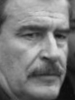

In [ ]:
cv2_imshow(X[0] * 255)

In [ ]:
def build_pos_pairs_classid(classid, max_num=5):
  imgs = classid_to_images[classid]
  pos_pairs = [(imgs[i], imgs[j])
                for i in range(len(imgs))
                for j in range(i + 1, len(imgs))]
  random.shuffle(pos_pairs)
  return pos_pairs[:max_num]

In [ ]:
def build_neg_pairs_classid(classid, classes, max_num=5):
  imgs = classid_to_images[classid]
  neg_classes_imageid = random.sample(classes, max_num+1)
  if classid in neg_classes_imageid:
    neg_classes_imageid.remove(classid)
  neg_pairs = []
  for id2 in range(max_num):
    img1 = imgs[random.randint(0, len(imgs)-1)]
    imgs2 = classid_to_images[neg_classes_imageid[id2]]
    img2 = imgs2[random.randint(0, len(imgs2) - 1)]
    neg_pairs += [(img1, img2)]
  return neg_pairs

In [ ]:
def build_test_train_data(num_classes, split=0.8):
  listX1 = []
  listX2 = []
  listY = []
  split = int(num_classes * split)
  classids = list(classid_to_name.keys())

  for id in range(split):
    pos = build_pos_pairs_classid(classids[id])
    neg = build_neg_pairs_classid(classids[id], classids[:split])
    for pair in pos:
      listX1 += [pair[0]]
      listX2 += [pair[1]]
      listY += [1]
    for pair in neg:
      listX1 += [pair[0]]
      listX2 += [pair[1]]
      listY += [0]
  perm = np.random.permutation(len(listX1))
  X1_ids_train = np.array(listX1)[perm]
  X2_ids_train = np.array(listX2)[perm]
  Y_ids_train = np.array(listY)[perm]

  listX1 = []
  listX2 = []
  listY = []

  # test
  for id in range(split, num_classes):
    pos = build_pos_pairs_classid(classids[id])
    neg = build_neg_pairs_classid(classids[id], classids[:split])
    for pair in pos:
      listX1 += [pair[0]]
      listX2 += [pair[1]]
      listY += [1]
    for pair in neg:
      listX1 += [pair[0]]
      listX2 += [pair[1]]
      listY += [0]
  X1_ids_test = np.array(listX1)
  X2_ids_test = np.array(listX2)
  Y_ids_test = np.array(listY)
  return (X1_ids_train, X2_ids_train, Y_ids_train.astype('float32'), X1_ids_test, X2_ids_test, Y_ids_test.astype('float32'))

In [ ]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_test_train_data(len(classid_to_name))
print('# train pairs', X1_ids_train.shape, X2_ids_train.shape, train_Y.shape, '# test pairs', X1_ids_test.shape, X2_ids_test.shape, test_Y.shape)

# train pairs (3380, 100, 75) (3380, 100, 75) (3380,) # test pairs (850, 100, 75) (850, 100, 75) (850,)


In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
  def __init__(self, X1, X2, Y, batch_size, all_imgs):
    self.batch_size = batch_size
    self.X1 = X1
    self.X2 = X2
    self.Y = Y
    self.imgs = all_imgs
    self.num_samples = Y.shape[0]
    self.indexes = np.arange(self.num_samples)

  def on_epoch_end(self):
    np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    imgs1 = self.X1[indexes]
    imgs2 = self.X2[indexes]
    return [[imgs1, imgs2], self.Y[indexes]]
  
  def __len__(self):
    return int(np.floor(self.num_samples / self.batch_size))

In [ ]:
def contrastive_loss(y_true, y_pred, margin=0.5):
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
def euclidean_distance(inputs):
  x, y = inputs
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
class CustomizedLossLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, input_shape):
    super().build(input_shape)

  def call(self, inputs):
    return euclidean_distance(inputs)


In [ ]:
step_fn = lambda x: K.cast(K.greater_equal(x, 0.5), dtype='float32')

In [ ]:
def simple_model_025():
  inp = Input((100, 75, 1), dtype='float32')
  x = Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01))(inp)
  x = Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01))(x)
  x = MaxPool2D((2,2))(x)
  x = Flatten()(x)
  x = Dropout(0.25)(x)
  x = Dense(50)(x)
  return (inp, x)

In [ ]:
def simple_model_05():
  inp = Input((100, 75, 1), dtype='float32')
  x = Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01))(inp)
  x = Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01))(x)
  x = MaxPool2D((2,2))(x)
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  x = Dense(50)(x)
  return (inp, x)

In [439]:
def model_1():
  inp = Input((100, 75, 1), dtype='float32')
  x = Conv2D(16, 3, activation="relu", padding="same")(inp)
  x = MaxPool2D((2,2))(x)
  x = Dropout(0.4)(x)
  x = Conv2D(32, 3, activation="relu", padding="same")(x)
  x = MaxPool2D((2,2))(x)
  x = Dropout(0.4)(x)
  x = Conv2D(64, 3, activation="relu", padding="same")(x)
  x = MaxPool2D((2,2))(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(256, activation="relu")(x)
  x = Dense(50, activation="sigmoid")(x)
  return (inp, x)

In [467]:
inp, x = simple_model_025()
shared_conv = Model(inputs=inp, outputs=x)

# Define Siamese network model
# create the left input and point to the base network
input_1 = Input((100, 75, 1), dtype='float32', name="left_input")

# create the right input and point to the base network
input_2 = Input((100, 75, 1), dtype='float32', name="right_input")

embedding1 = shared_conv(input_1)
embedding2 = shared_conv(input_2)
euclidean_dis_layer_lambda = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)

# measure the similarity of the two vector outputs
output_layer = euclidean_dis_layer_lambda([embedding1, embedding2])

model = Model([input_1, input_2], output_layer)
# specify the inputs and output of the model
model.summary()


Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 right_input (InputLayer)       [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_94 (Functional)          (None, 50)           1482530     ['left_input[0][0]',             
                                                                  'right_input[0][0]']     

In [430]:
# Build a dataloader
myGenerator = CustomDataGen(X1_ids_train, 
                            X2_ids_train, 
                            train_Y, 
                            128, 
                            X)

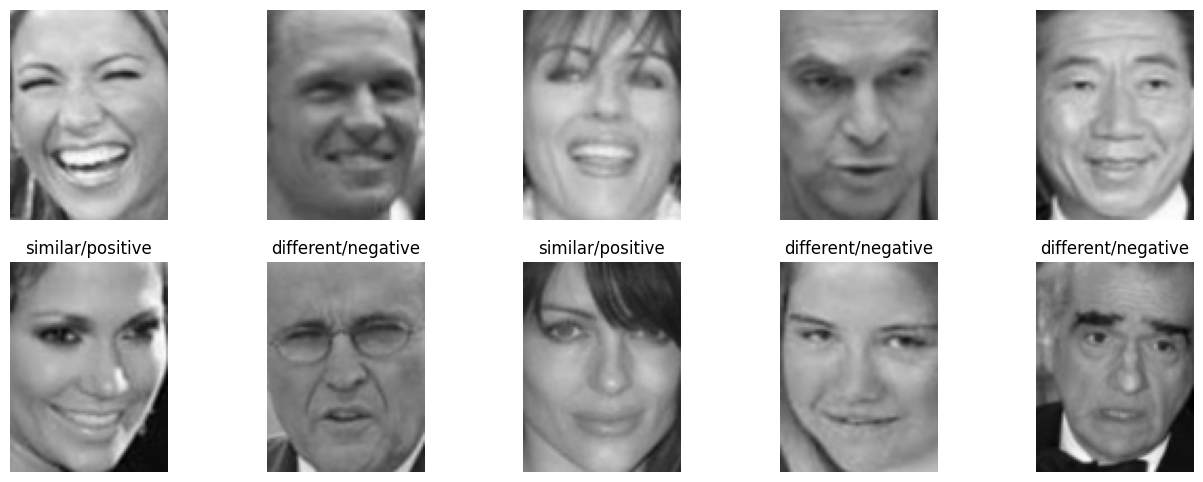

In [ ]:
# Display a few pairs of training images
[x1, x2], y_label = myGenerator[0]

plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(x1[i], cv2.COLOR_GRAY2RGB)) # Convert image color format, as Opencv load image in RGR format
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(x2[i], cv2.COLOR_GRAY2RGB))
    if y_label[i]==1.0:
        plt.title("similar/positive")
    else:
        plt.title("different/negative")
    plt.axis('off')
plt.show()


In [472]:
NUM_EPOCH = 200
model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(myGenerator, steps_per_epoch=train_Y.shape[0] // 128, epochs=NUM_EPOCH, validation_data=([X1_ids_test, X2_ids_test], test_Y), verbose=1, callbacks=[early_stopping])

Epoch 1/200
26/26 [==============================] - 4s 55ms/step - loss: 0.2052 - accuracy: 0.4922 - val_loss: 0.1629 - val_accuracy: 0.5000
Epoch 2/200
26/26 [==============================] - 1s 44ms/step - loss: 0.1381 - accuracy: 0.4889 - val_loss: 0.1200 - val_accuracy: 0.4788
Epoch 3/200
26/26 [==============================] - 1s 45ms/step - loss: 0.1016 - accuracy: 0.4739 - val_loss: 0.0994 - val_accuracy: 0.4906
Epoch 4/200
26/26 [==============================] - 1s 43ms/step - loss: 0.0788 - accuracy: 0.4612 - val_loss: 0.0852 - val_accuracy: 0.4788
Epoch 5/200
26/26 [==============================] - 1s 43ms/step - loss: 0.0643 - accuracy: 0.4591 - val_loss: 0.0790 - val_accuracy: 0.4824
Epoch 6/200
26/26 [==============================] - 1s 45ms/step - loss: 0.0541 - accuracy: 0.4429 - val_loss: 0.0734 - val_accuracy: 0.4729
Epoch 7/200
26/26 [==============================] - 1s 43ms/step - loss: 0.0475 - accuracy: 0.4408 - val_loss: 0.0708 - val_accuracy: 0.4635
Epoch 

In [ ]:
import time
shared_conv.save_weights("/content/drive/MyDrive/Colab Notebooks/ISSM-PM/" + "model1_" + "shared_conv_" + str(time.time()) + ".h5")
model.save_weights("/content/drive/MyDrive/Colab Notebooks/ISSM-PM/" + "model1_" + "siamese_model_" + str(time.time()) + ".h5")

In [458]:
classid_to_imageid = {}
for idx, t in enumerate(y):
  if t in classid_to_imageid:
    classid_to_imageid[t].append(idx)
  else:
    classid_to_imageid[t] = [idx]

In [468]:
# Extract features for all images
emb = shared_conv.predict(X)

188/188 [==============================] - 0s 2ms/step


Query person name: James Blake


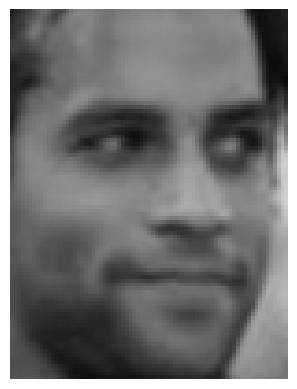

Person name:  James Blake Distance:  0.0


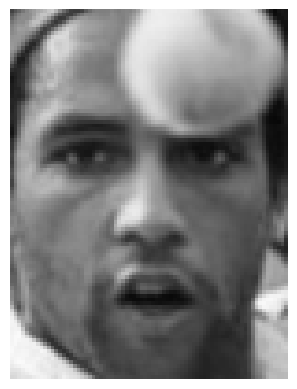

Person name:  Donald Rumsfeld Distance:  0.21432232856661382


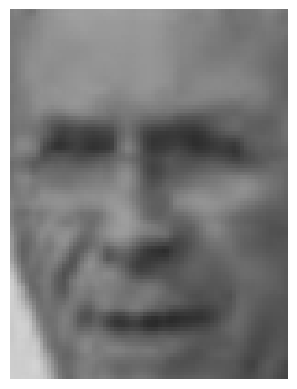

Person name:  John Paul II Distance:  0.21886855131455896


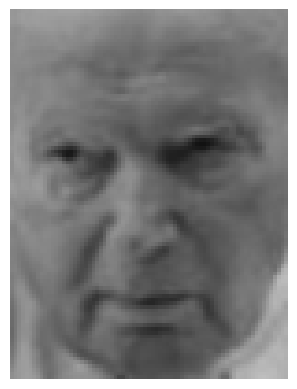

In [469]:
# - Randomly select a query image, apply the the pre-trained siamese model to find similar images from the data `all_imgs`
# - Display the query image, top three similar images, and their respective dissimlarity score.
# Define functions used to pickup the smallest distance photo and display

def smallest_distance(x, emb, topn=3):
  from scipy.spatial.distance import cdist
  dist = cdist(x, emb) 
  ids = np.argsort(dist)#[::-1]
  return [(id, dist[0,id]) for id in ids[0,:topn]]

def display(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    plt.show()

# Choose a random test photo
class_id = 158
query_id = random.choice(classid_to_imageid[class_id])
print("Query person name:", classid_to_name[class_id])
display(random.choice(classid_to_images[class_id]))


for result_id, dist in smallest_distance(emb[query_id:query_id+1,:], emb):
  class_name = classid_to_name[y[result_id]]
  print('Person name: ', class_name, 'Distance: ', dist)    
  display(X[result_id])


In [475]:
def make_predictions():
  preds = []
  for class_id in y:
    query_id = random.choice(classid_to_imageid[class_id])
    result_id, dist = smallest_distance(emb[query_id:query_id+1,:], emb)[1]
    preds.append(y[result_id])
  return preds

y_pred = make_predictions()

In [476]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y)

0.11010860484544695

In [477]:
ref_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ISSM-PM/yao1.jpg")
test_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ISSM-PM/yao2.jpg")
ref_img = cv2.resize(ref_img, (75, 100), cv2.INTER_LINEAR)
test_img = cv2.resize(test_img, (75, 100), cv2.INTER_LINEAR)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)



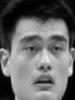

In [ ]:
cv2_imshow(ref_img)

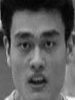

In [ ]:
cv2_imshow(test_img)

In [464]:
#emb[0]

ref_emb = shared_conv.predict(np.array([ref_img]))
test_emb = shared_conv.predict(np.array([test_img]))
dist = smallest_distance(test_emb, emb)
print(dist)
for d in dist:
  resultid, dis = d
  print(classid_to_name[y[resultid]])

1/1 [==============================] - 0s 18ms/step
[(2192, 59.52302234805894), (5769, 59.55203990112485), (352, 59.56220795255075)]
Walter Mondale
Tony Blair
Jiang Zemin


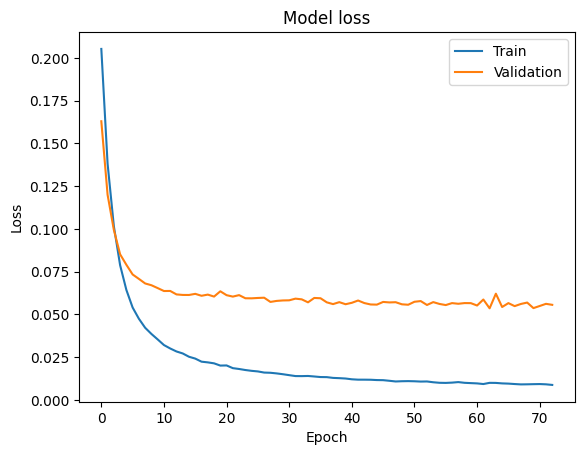

In [473]:
import matplotlib.pyplot as plt

# plot the training and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

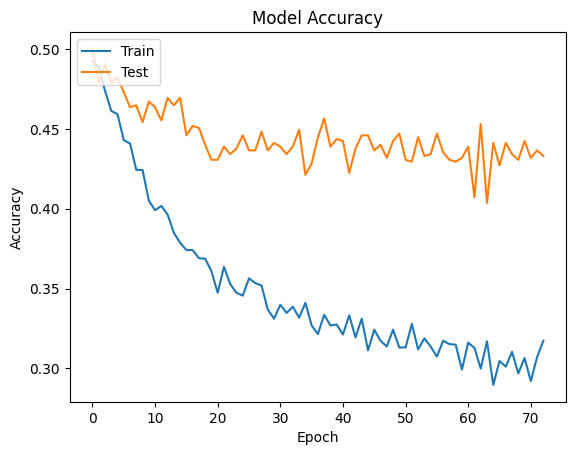

In [474]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def define_model_1():
  inp = Input((100, 75, 1), dtype='float32')
  x = Conv2D(16, 3, activation="relu", padding="same")(inp)
  x = Conv2D(16, 3, activation="relu", padding="same")(x)
  x = MaxPool2D((2,2))(x)
  x = Conv2D(32, 3, activation="relu", padding="same")(x)
  x = Conv2D(32, 3, activation="relu", padding="same")(x)
  x = MaxPool2D((2,2))(x)
  x = Conv2D(64, 3, activation="relu", padding="same")(x)
  x = Conv2D(64, 3, activation="relu", padding="same")(x)
  x = MaxPool2D((2,2))(x)
  x = Conv2D(128, 3, activation="relu", padding="same")(x)
  x = Flatten()(x)
  x = Dense(1024, activation="relu")(x)
  x = Dense(512, activation="relu")(x)
  x = Dense(128, activation="softmax")(x)
  return x

